**Quiz Computer Vision**

**Kelompok 10**

Anggota Kelompok:

Nama  : Rio Pramana, Debora

NIM   : 2440016804, 2440087214

Kelas : LA01

# Import libraries

In [ ]:
#import libraries
import cv2 
from matplotlib import pyplot as plt
import numpy as np
from os import listdir
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Load dataset

Our device was not able to handle the processing of all 37500 images of the dataset. Therefore, we had to reduce the number of data to 10% of the original training dataset (2500 training data). We only took 10 sample image from the test dataset (from 12500 images) because all of the test dataset are unlabeled, so we only took several images just to show how well the model/algorithm could perform to predict whether an image is a cat or a dog

In [2]:
#Read dataset
TRAIN_PATH = './Images/train/reduced_train'
TEST_PATH = './Images/reduced_test'

train_filename_list = listdir(TRAIN_PATH)

We also resized each image to 128 x 128 to make the image processing easier

In [3]:
def get_dataset(path, is_train=1):
  filename_list = listdir(path)
  images = []
  classes = []

  for filename in filename_list:
    image = cv2.resize(cv2.imread(f"{path}/{filename}"), (128,128))
    images.append(image)
    if (is_train == 1):
        img_class = filename.split('.')[0]
        if img_class == "dog": 
            id = 1
        else:
            id = 0
        classes.append(id)

  return images, classes

Get both dataset:

In [4]:
train_images, train_classes = get_dataset(TRAIN_PATH)
test_images, _ = get_dataset(TEST_PATH, 0)

# Collect all the descriptors from the images

First, we need to create/instantiate a SIFT object (We are using SIFT class from opencv that is used to extract keypoints and computing descriptors using SIFT algorithm proposed by D. Lowe)

Then, we use that object to only get the descriptors from each image

Below is the function to get descriptors from each image in a list of images (for example: list of train images)

In [5]:
#Extract features
sift = cv2.SIFT_create()

def get_descriptors(img_list):
    descriptors = []

    for image in img_list:
        _, desc = sift.detectAndCompute(image, None)
        descriptors.append(desc)
    
    return descriptors

Get descriptors from training & test dataset:

In [6]:
train_desc = get_descriptors(train_images)
test_desc = get_descriptors(test_images)

In [7]:
print(len(train_desc))

2500


Before moving on, we need to apply vertical stack to stack the sequence of arrays vertically into a single array. Therefore, each training image's descriptors will be collected/put into a single list (not lists in a list) which will act as the **bag of descriptors**

In [8]:
desc_bag = train_desc[0]
for descriptor in train_desc[1:]:
    desc_bag = np.vstack((desc_bag, descriptor))

desc_bag = np.float32(desc_bag)

In [9]:
print(len(desc_bag))

323773


# Cluster descriptors into k number of clusters

For k, we put it the same as the number of categories/classes in this dataset, which is 2

We used the default number of iterations (20)

In [10]:
centroids, _ = kmeans(desc_bag,2,20)

# For every image in the dataset, counts how frequently the different features in the dictionary occurs

For each SIFT descriptor in the image, we find the closest cluster center (centroids) and increment its corresponding count in the vector v by 1 using vector quantization from scipy

In [11]:
def get_img_features(img_list, centroids, descriptors):
    image_features = np.zeros((len(img_list), len(centroids)), "float32")
    for i in range(len(img_list)):
        words, dist = vq(descriptors[i], centroids)
        for w in words:
            image_features[i][w] +=1
            
    return image_features

In [12]:
train_features = get_img_features(train_images, centroids, train_desc)
test_features = get_img_features(test_images, centroids, test_desc)

# Normalize the histogram

To normalize the features, we use StandardScaler()

In [13]:
scaler = StandardScaler()
scaler = scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

# Create k-NN model

To predict test images, we use k-NN classifier with n_neighbors = 1 because it gave the best results from our experiments (we tried the value 1 - 6 and the best performing one is with n_neighbors = 1)

In [36]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_features, np.array(train_classes))

KNeighborsClassifier(n_neighbors=1)

# Evaluate Performance

Because the test dataset are all unlabeled, we first tried to predict the train dataset

In [37]:
train_pred = knn.predict(train_features)
print(classification_report(train_classes, train_pred, target_names = ['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.88      0.88      0.88      1250
         dog       0.88      0.88      0.88      1250

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



It managed to achieve the same performance (88%) on all aspects

Next, we tried to predict the 10 test images (we picked the first 5 dog images and 5 cat images from the test dataset)

In [38]:
test_pred = knn.predict(test_features)

Show the prediction:

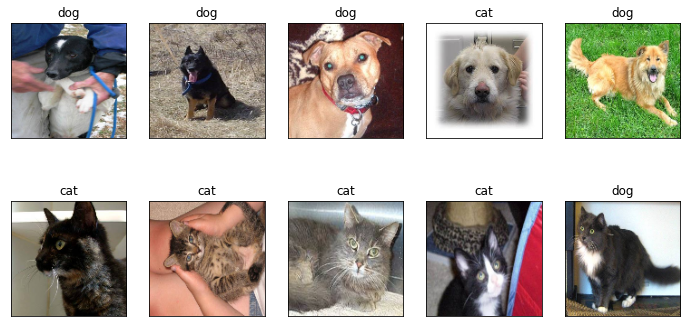

In [39]:
plt.figure(figsize=(12,6))
for id, (result, image) in enumerate(zip(test_pred, test_images)):
    plt.subplot(2, 5, id+1)
    if (test_pred[id] == 1):
        plt.title("dog")
    else:
        plt.title("cat")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
plt.show()

The model was able to achieve a good performance (accurately predict 8/10 test images). However, the model performance could probably be even higher if it was able to use the whole dataset (37500 images) without having to resize the images (to 128 x 128) because it might also affect the images' descriptors collection